In [1]:
import os
try:
    os.chdir('/content')
    !git clone https://github.com/billyhjm/PHM_Education.git
    os.chdir('/content/PHM_Education')
except:
    pass

# Feature Practice - CWRU

In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import signal, stats
from scipy.signal import hilbert
from scipy.signal import lfilter

import sklearn
from sklearn.model_selection import train_test_split

In [3]:
import z_dependancy as z_dep

%matplotlib

In [4]:
%matplotlib inline

In [5]:
plt.rc('font', size=20)

In [6]:
fs = 12000;

## 베어링 주파수 DB 만들기

In [7]:
F_BPFI = 5.4152;
F_BPFO = 3.5848;
F_FTF = 0.398;
F_BSF = 4.7135

In [8]:
F_shaft_rpm = 1797; 
F_shaft = F_shaft_rpm/60 

In [9]:
F_BPFI_w = F_BPFI*F_shaft;
F_BPFO_w = F_BPFO*F_shaft;
F_FTF_w = F_FTF*F_shaft;
F_BSF_w = F_BSF*F_shaft;

## 신호 로드하고 그려보기

In [10]:
data = np.array(pd.read_csv('./data/data_normal.csv'))
print(np.shape(data))
print(data)
v_n = data[:,1]

(243938, 2)
[[0.00000000e+00 1.45667273e-01]
 [1.00000000e+00 9.77963636e-02]
 [2.00000000e+00 5.48563636e-02]
 ...
 [2.43935000e+05 1.40530909e-01]
 [2.43936000e+05 9.55363636e-02]
 [2.43937000e+05 9.01945455e-02]]


In [11]:
data = np.array(pd.read_csv('./data/data_fault.csv'))
print(np.shape(data))
print(data)
v_f = data[:,1]

(121846, 2)
[[ 0.00000000e+00  2.27353293e-03]
 [ 1.00000000e+00 -1.04947904e-01]
 [ 2.00000000e+00  8.20095808e-02]
 ...
 [ 1.21843000e+05 -1.12377485e-01]
 [ 1.21844000e+05 -8.52980838e-02]
 [ 1.21845000e+05 -2.62674251e-02]]


(-4.0, 4.0)

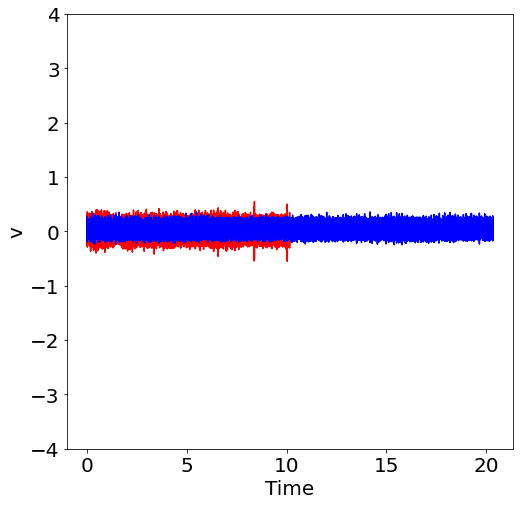

In [12]:
t_n=np.arange(0,len(v_n),1)/fs  # 0 초부터 
t_f = np.arange(0, len(v_f), 1)/fs

plt.figure(figsize=(8,8))
plt.plot(t_f,v_f,'r')
plt.plot(t_n,v_n,'b')
plt.xlabel('Time')
plt.ylabel('v')
plt.ylim([-4,4])

## 신호 자르기

In [13]:
print('normal data size: {}'.format(v_n.shape))
print('fault data size: {}'.format(v_f.shape))

normal data size: (243938,)
fault data size: (121846,)


In [14]:
sample_size = 2000
num_n = int(np.floor(v_n.shape[0]/sample_size))
num_f = int(np.floor(v_f.shape[0]/sample_size))

print('normal dataset number: {}'.format(num_n))
print('fault dataset number: {}'.format(num_f))

normal dataset number: 121
fault dataset number: 60


In [15]:
v_data_n = []
v_data_f = []

for n in range(0,num_n):
    v_data_n.append(v_n[n*sample_size:(n+1)*sample_size])
    
for n in range(0,num_f):
    v_data_f.append(v_f[n*sample_size:(n+1)*sample_size])
    
v_data_n=np.squeeze(np.array(v_data_n))
v_data_f=np.squeeze(np.array(v_data_f))

y_n = np.zeros((num_n,))
y_f = np.ones((num_f,))

print('normal dataset size: {}'.format(v_data_n.shape))
print('fault dataset size: {}'.format(v_data_f.shape))

normal dataset size: (121, 2000)
fault dataset size: (60, 2000)


### Sample Data 비교해보기

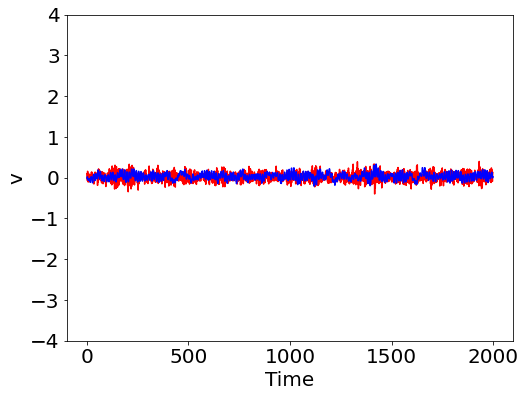

Text(0, 0.5, '|Y|')

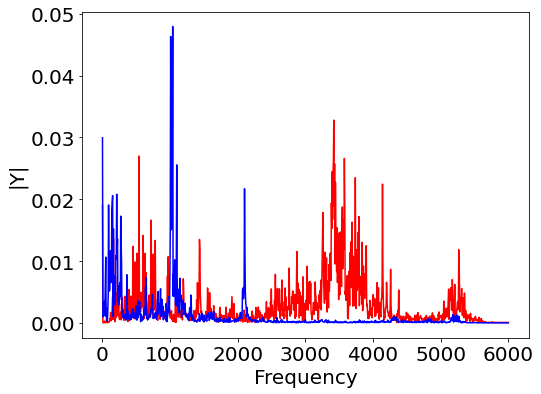

In [16]:
nn = int(np.random.choice(num_n,1))
nf = int(np.random.choice(num_f,1))

plt.figure(figsize=(8,6))
plt.plot(v_data_f[nf,:],'r')
plt.plot(v_data_n[nn,:],'b')
plt.xlabel('Time');plt.ylabel('v');
plt.ylim([-4,4])
plt.show()


[f_n, A_n] = z_dep.z_fft_simple(v_data_n[nn,:],fs);
[f_f, A_f] = z_dep.z_fft_simple(v_data_f[nf,:],fs);

plt.figure(figsize=(8,6))
plt.plot(f_f,A_f,'r')
plt.plot(f_n, A_n, 'b')
plt.xlabel('Frequency');plt.ylabel('|Y|')


# Feature 추출해보기

In [19]:
band_energy_and_filter = [2000,4500]
band_enrgy_from_envelope = np.matrix([
                [F_BPFO_w*0.9, F_BPFO_w*1.1],
                [2*F_BPFO_w*0.9, 2*F_BPFO_w*1.1],
                [3*F_BPFO_w*0.9, 3*F_BPFO_w*1.1]
                ])

print(f'Band Energy and Filter Range: {band_energy_and_filter}')
print(f'Band Energy from Envelope: {band_enrgy_from_envelope}')

Band Energy and Filter Range: [2000, 4500]
Band Energy from Envelope: [[ 96.628284 118.101236]
 [193.256568 236.202472]
 [289.884852 354.303708]]


In [21]:
feature_n = []
feature_f = []

for n in range(0,num_n):
    feature_n_tmp,feature_name = z_dep.z_feature(v_data_n[n,:], fs, band_energy_and_filter, band_enrgy_from_envelope);
    feature_n.append(feature_n_tmp)
    
for n in range(0,num_f):
    feature_f_tmp,_ = z_dep.z_feature(v_data_f[n,:], fs, band_energy_and_filter, band_enrgy_from_envelope);
    feature_f.append(feature_f_tmp)
    
feature_n = np.array(feature_n)
feature_f = np.array(feature_f)

print('normal feature size: {}'.format(feature_n.shape))
print('fault feature size: {}'.format(feature_f.shape))

normal feature size: (121, 12)
fault feature size: (60, 12)


## Feature들의 평균값 비교 (정상 vs 고장)

In [22]:
feature_n_mean = np.mean(feature_n,axis=0)
feature_f_mean = np.mean(feature_f,axis=0)

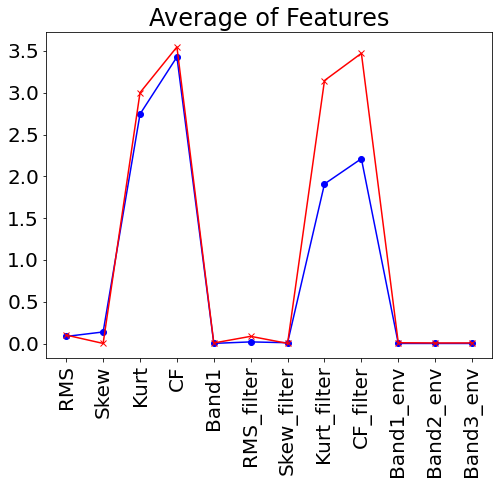

In [23]:
plt.figure(figsize=(8,6))
plt.plot(feature_n_mean,'-bo')
plt.plot(feature_f_mean,'-rx')
plt.title('Average of Features')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical');
plt.show()

## Index 두개를 골라 산점도 그려보기

Text(0, 0.5, 'CF_filter')

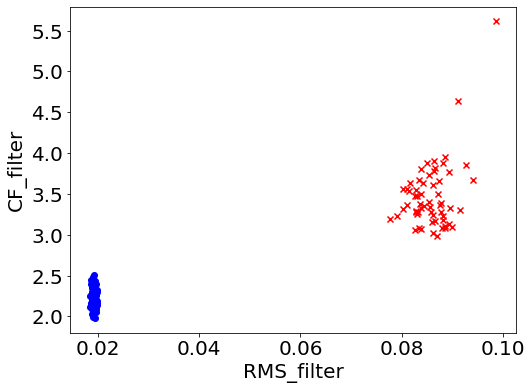

In [24]:
idx1 = 5;idx2 = 8
# idx1 = 8;idx2 = 14

plt.figure(figsize=(8,6))
plt.scatter(feature_n[:,idx1],feature_n[:,idx2],marker='o',color='b')
plt.scatter(feature_f[:,idx1],feature_f[:,idx2],marker='x',color='r')

plt.xlabel(feature_name[idx1])
plt.ylabel(feature_name[idx2])

## 간단한 머신러닝 적용해보기

### Data set (Normal Fault) 합치기

In [25]:
x = np.concatenate((feature_n,feature_f),0)
y = np.concatenate((y_n,y_f),0)
print('Combined Dataset x size: {}'.format(x.shape))
print('Combined Dataset y size: {}'.format(y.shape))

Combined Dataset x size: (181, 12)
Combined Dataset y size: (181,)


Text(0, 0.5, 'CF_filter')

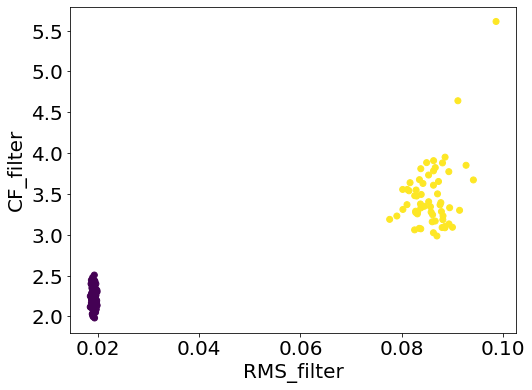

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(x[:,idx1],x[:,idx2],c=y)
plt.xlabel(feature_name[idx1])
plt.ylabel(feature_name[idx2])

### Training Testing set 나누기

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Training size: {}'.format(x_train.shape))
print('Test size: {}'.format(x_test.shape))

Training size: (144, 12)
Test size: (37, 12)


## sklearn으로 학습/평가 해보기

In [28]:
import z_ML_utils
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

https://scikit-learn.org/stable/tutorial/basic/tutorial.html

    fit(x_train, y_train)     
    predict(x_test)           
    score(x_test, y_test)     ## 모델 정확도 평가를 위한 mean accuracy

## Logistic Regression

1.0


<module 'matplotlib.pyplot' from 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

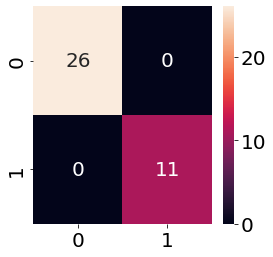

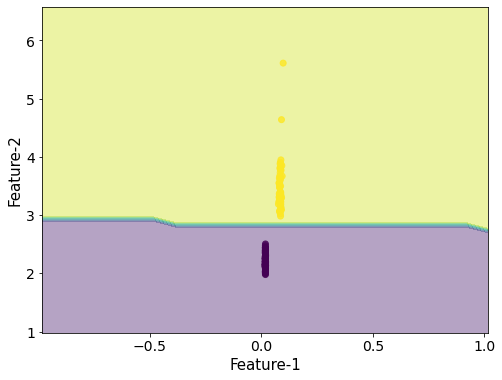

In [29]:
solver='lbfgs'
model = LogisticRegression(solver=solver)
model.fit(x_train,y_train)
y_test_pred = model.predict(x_test)    

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,LogisticRegression, idx1=idx1, idx2=idx2, solver=solver)

## Neural Network

1.0


<module 'matplotlib.pyplot' from 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

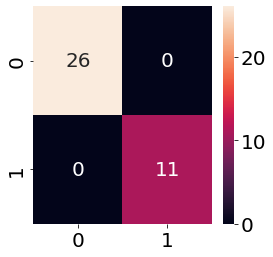

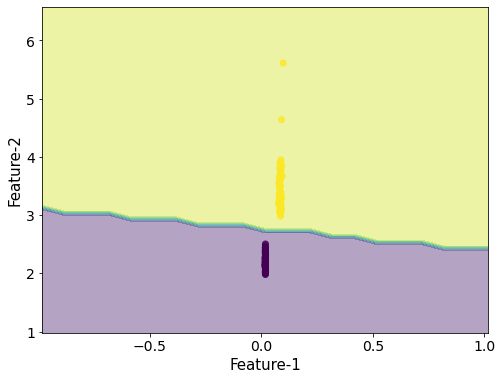

In [30]:
solver='lbfgs'
hidden_layer_sizes=(10, 10, 10)

model = MLPClassifier(solver=solver,hidden_layer_sizes=hidden_layer_sizes)
model.fit(x_train,y_train)
y_test_pred = model.predict(x_test)    

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,MLPClassifier, idx1=idx1, idx2=idx2, solver=solver,hidden_layer_sizes=hidden_layer_sizes)

## Support Vector Machine (SVM)

### Linear

1.0


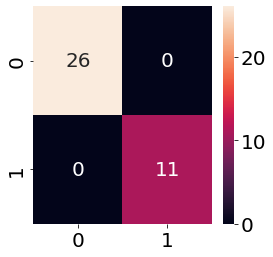

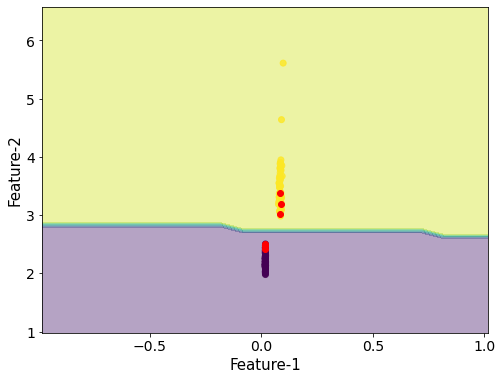

In [31]:
kernel='linear'

model = svm.SVC(kernel=kernel)
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,svm.SVC, idx1=idx1, idx2=idx2, kernel=kernel)

support_vectors = model.support_vectors_
plt.scatter(support_vectors[:,idx1], support_vectors[:,idx2], color='red')

### Poly

1.0


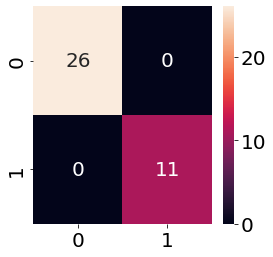

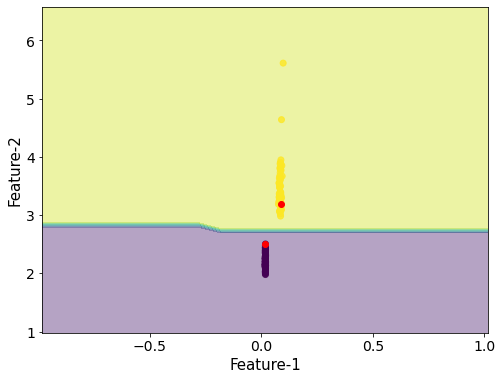

In [32]:
kernel='poly'
gamma = 'auto'

model = svm.SVC(kernel=kernel, gamma=gamma)
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,svm.SVC, idx1=idx1, idx2=idx2, kernel=kernel, gamma=gamma)

support_vectors = model.support_vectors_
plt.scatter(support_vectors[:,idx1], support_vectors[:,idx2], color='red')

### RBF

1.0


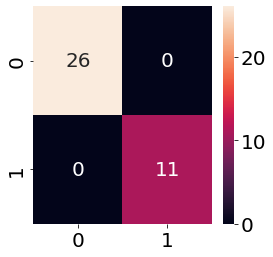

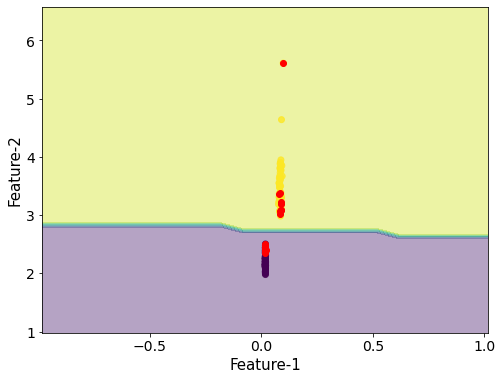

In [33]:
kernel='rbf'
gamma = 'auto'

model = svm.SVC(kernel=kernel, gamma=gamma)
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,svm.SVC, idx1=idx1, idx2=idx2, kernel=kernel, gamma=gamma)

support_vectors = model.support_vectors_
plt.scatter(support_vectors[:,idx1], support_vectors[:,idx2], color='red')

## Decision Tree

1.0


<module 'matplotlib.pyplot' from 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

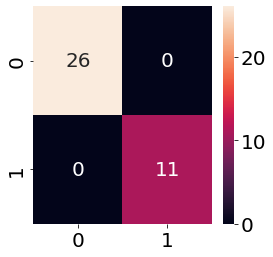

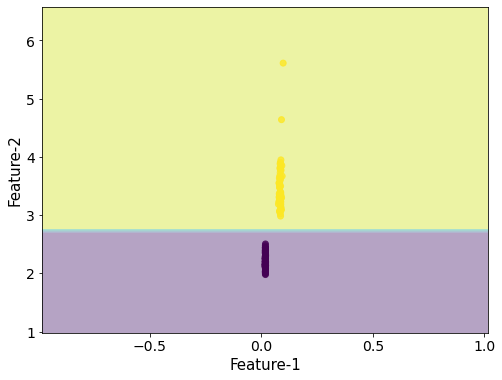

In [34]:
model = tree.DecisionTreeClassifier()
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)
print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,tree.DecisionTreeClassifier, idx1=idx1, idx2=idx2)

### Random Forest

1.0


<module 'matplotlib.pyplot' from 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

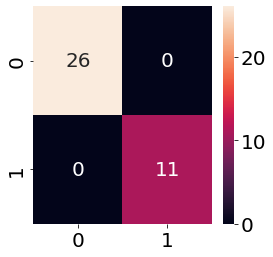

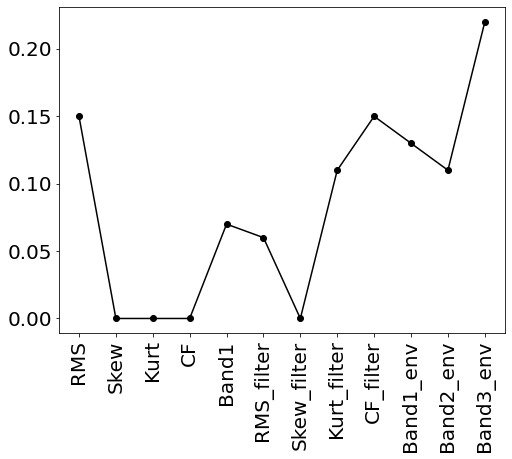

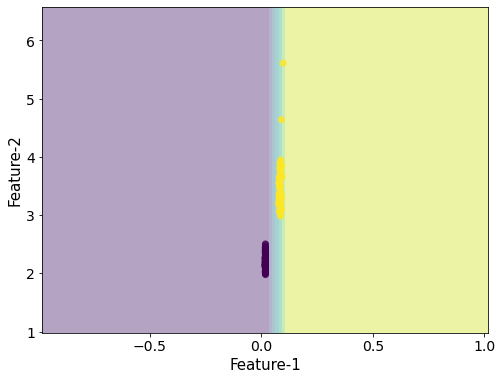

In [35]:
max_depth = 5
n_estimators = 100
max_features = 5

model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)
model.fit(x_train, y_train)
importance = model.feature_importances_
y_test_pred = model.predict(x_test)

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

print(model.score(x_test, y_test))
plt.figure(figsize=(8,6))
plt.plot(importance,'-ko')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical');
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,RandomForestClassifier, idx1=idx1, idx2=idx2, max_depth=max_depth, n_estimators=n_estimators)

## XGBoost 학습/평가 해보기

    conda install -c anaconda py-xgboost

In [36]:
from xgboost import plot_importance
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
n_estimator = 100
colsample_bytree = 0.1
max_depth = 10

model = XGBClassifier(n_estimator=n_estimator,colsample_bytree = colsample_bytree,max_depth = max_depth)
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
importance = model.feature_importances_

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

plt.figure(figsize=(8,6))
plt.plot(importance,'-ko')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical');

fig,ax = plt.subplots()
plot_importance(model,ax=ax)

print(model.score(x_test, y_test))
# print(metrics(y_test,y_test_pred))
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,XGBClassifier, idx1=idx1, idx2=idx2, n_estimator=n_estimator,colsample_bytree = colsample_bytree,max_depth = max_depth)


## LightGBM 학습/평가 해보기

    conda install -c conda-forge lightgbm 

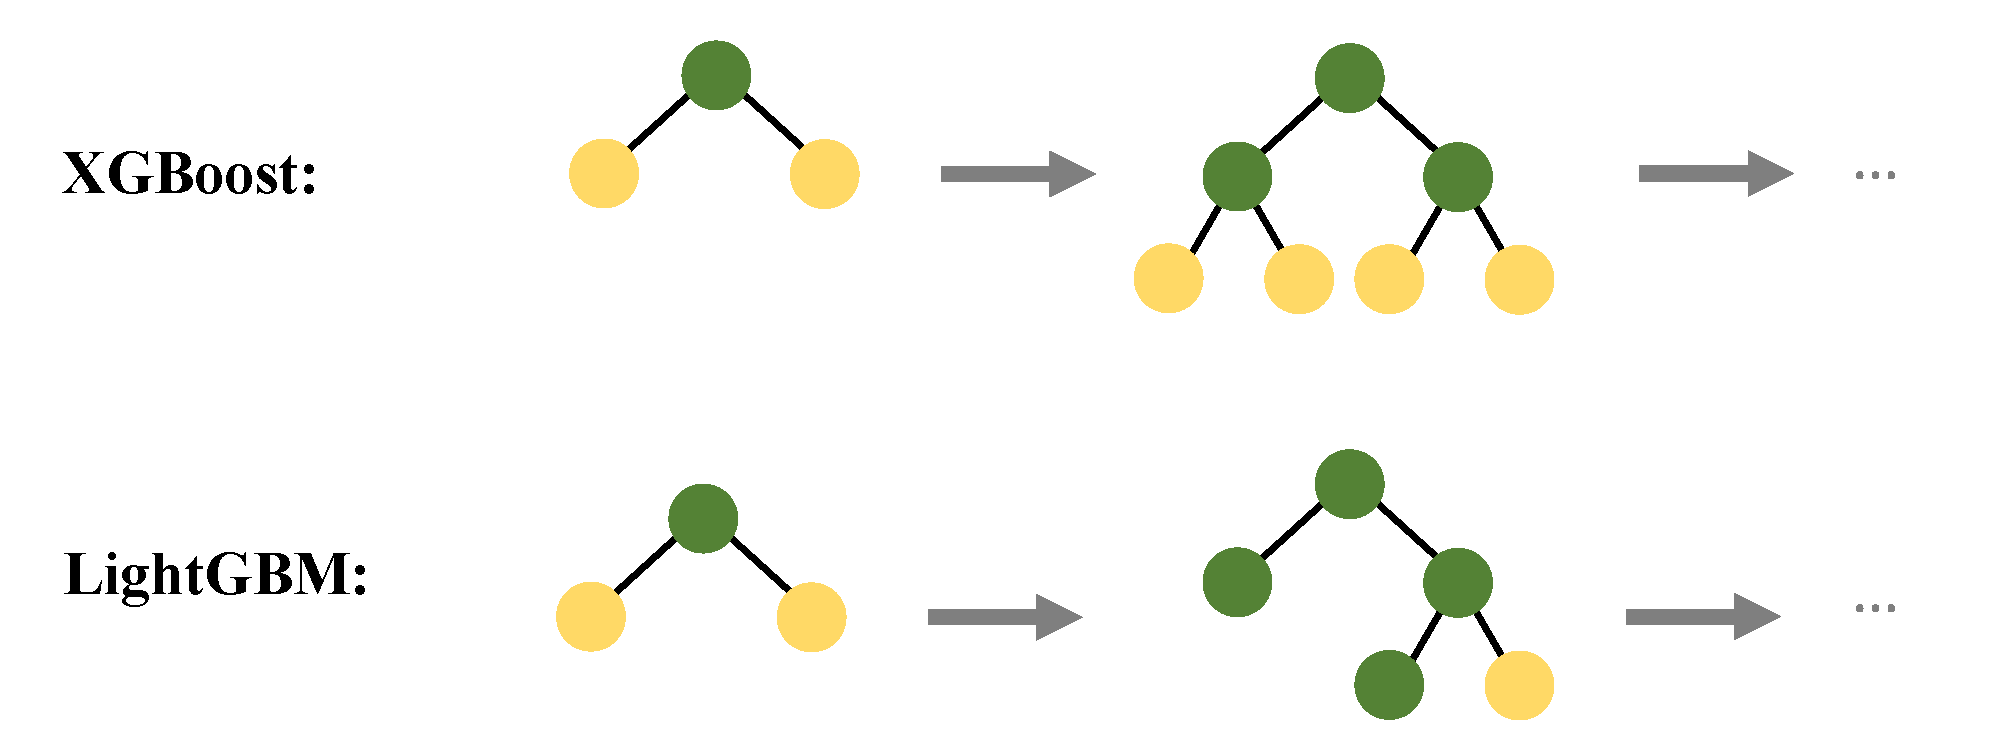
https://www.mdpi.com/2571-9394/2/3/15

In [ ]:
from lightgbm import LGBMClassifier, plot_importance

In [ ]:
n_estimator = 100
colsample_bytree = 0.1

model = LGBMClassifier(n_estimator=n_estimator,colsample_bytree = colsample_bytree)
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
importance = model.feature_importances_

plt.figure(figsize=(4,4))
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True)

plt.figure(figsize=(8,6))
plt.plot(importance,'-ko')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical');

fig,ax = plt.subplots()
plot_importance(model,ax=ax)

print(model.score(x_test, y_test))
# print(metrics(y_test,y_test_pred))
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
z_ML_utils.plot_decision_boundaries(x,y,XGBClassifier, idx1=idx1, idx2=idx2, n_estimator=n_estimator,colsample_bytree = colsample_bytree)